# 1. Load modules

In [1]:
#%matplotlib widget 
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker
from scipy import optimize
import os, sys
from pathlib import Path
import xrdpy

In [2]:
print(f'xrdpy version: {xrdpy.__version__}')
print(f'xrdpy path: {xrdpy.__path__}')

xrdpy version: 0.0.3


# 2. Set up the xrd-file path

In [3]:
xrdpy_test_path = Path().absolute()

In [4]:
filepath = os.path.join(xrdpy_test_path,"xrd_files")
filename = "NT3334C_RSM_w2T-2T-105AlN-AlGaN_fast.xrdml"

In [5]:
savefig = True
save_fig_path = os.path.join(xrdpy_test_path,"../imgs")

In [6]:
gen_fns = xrdpy.general_fns(print_log='low')
xrd_ = xrdpy.xrd(print_log='low')
xrd_plt = xrdpy.plottings(save_figure_dir=save_fig_path, print_log='low')

# 3. Set default variables

#### Variable source: https://www.ioffe.ru/SVA/NSM/Semicond/

In [7]:
alloy_type='ternary' 
structure_type='wz'

# Lattice parameters for AlN and GaN binaries
AlN_a, AlN_c = 3.112, 4.982
GaN_a, GaN_c = 3.189, 5.185    

# Cij parameters for AlN and GaN binaries
GaN_C13 = 106
GaN_C33 = 398
AlN_C13 = 108
AlN_C33 = 373

# Bowing parameters
bowing_a = 0.0
bowing_c = 0.0
bowing_C13 = 0.0
bowing_C33 = 0.0

# reciprocal axes are multiplited by this number to make enlarge axes
mul_fact = [10000, 10000] # along [Qx, Qy]

# a_lp_bin: [a_lattice_parameter bin_1, a_lattice_parameter bin_2, bowing]
# For ternary_wz we need followings: [a_lp_bin, c_lp_bin, c13_bin, c33_bin]
# Alloy_params = x*list_binary_parameters[i][0] + (1-x)*list_binary_parameters[i][1]+bowing*x*1-x
# WARNING: Maintain the order of data given for material parameters for all list below. 
# E.g. Do not do like [[AlN_data, GaN_data, bowing],[GaN_data, AlN_data, bowing],...]
list_binary_parameters = [[AlN_a, GaN_a, bowing_a], [AlN_c, GaN_c, bowing_c],
                          [AlN_C13, GaN_C13, bowing_C13], [AlN_C33, GaN_C33, bowing_C33]]

# Reflection plane hkl
hkl = (1,0,5)

# 4. Read xrd-file

## 4.1 Real space data

In [8]:
lambda_wavelength, two_theta_values, omega_values, rsm_intesity  = \
    xrd_.xrd_read_data(xrd_file_name=os.path.join(filepath, filename))
# X-ray wave number
R = 1/lambda_wavelength

Wavelength used (from xrd file): 1.5405980
Intensity unit (from xrd file): counts/seconds


## 4.2 Reciprocal space conversion

In [9]:
total_two_theta_in_row = np.shape(rsm_intesity)[1]
rec_space_x, rec_space_y = xrd_.Qxy(omega=omega_values, two_theta=two_theta_values, 
                                    total_two_theta_in_row=total_two_theta_in_row,
                                    R=R, mul_fact=mul_fact)

# 5. Perform post-calculations from maps

## 5.1 Estimate the compostion and strain relaxation of other peaks in reciprocal space map

In [10]:
find_results_4_peak = [3730, 9905]

### 5.1.1 Calculate reference point theoretically

In [11]:
# Calculating only for AlN as this is my reference point
rec_space_theor_ref_xy = xrd_.Qxy_theor(AlN_a, AlN_c, hkl=hkl, structure_type=structure_type) 
print(f'Theoretically calculated reference points: {rec_space_theor_ref_xy}')

Theoretically calculated reference points: (3710.477308416618, 10036.130068245684)


### 5.1.2 Get or define the reference point in data
##### E.g. Here we use the highest maximum point as reference (AlN). This will be used as full strain line reference. You use the above figure to decide which point to use as reference.

In [12]:
# Note: for this tutorial we assume the maximum intensity point is the reference experimental peak
# Moreover, in tutorial 03_ we do better algorithm to find this peak instaed of using argmax which
# is required as out data is noisy in general.
max_intensity_pos = np.unravel_index(np.argmax(rsm_intesity, axis=None), rsm_intesity.shape)
x_coord_max = rec_space_x[max_intensity_pos]
y_coord_max = rec_space_y[max_intensity_pos]
print(f'Reference experimental peak/point (before shift): {x_coord_max}, {y_coord_max}')

Reference experimental peak/point (before shift): 3730.119452276986, 10033.145022343728


### 5.1.3 Calculate shift required to map experimental referernce on theoretically calculated reference

In [13]:
# Calcuate shift amount
shift_xy_ = np.array([rec_space_theor_ref_xy[0]-x_coord_max, rec_space_theor_ref_xy[1]-y_coord_max])
print(f'Shift of refence peak: {shift_xy_}')

Shift of refence peak: [-19.64214386   2.9850459 ]


### 5.1.4 Shift experimental data

In [14]:
rec_space_x_shift = rec_space_x + shift_xy_[0]  # Shifting x-coordinates
rec_space_y_shift = rec_space_y + shift_xy_[1]  #shifting y-coordinates
# Add the shift to find_results_for_peak in experimental data
find_results_4_peak_shift = [find_results_4_peak[i] + shift_xy_[i] for i in range(2)]
# Add the shift to reference peak in experimental data
reference_peak = [x_coord_max+shift_xy_[0], y_coord_max+shift_xy_[1]]
print(f'Reference experimental peak/point (after shift): {reference_peak}')
print(f'Determine results for experimental peak/point (after shift): {find_results_4_peak_shift}')

Reference experimental peak/point (after shift): [3710.477308416618, 10036.130068245684]
Determine results for experimental peak/point (after shift): [3710.357856139632, 9907.985045901956]


### 5.1.5 Calculate composition and relxation for the other peak

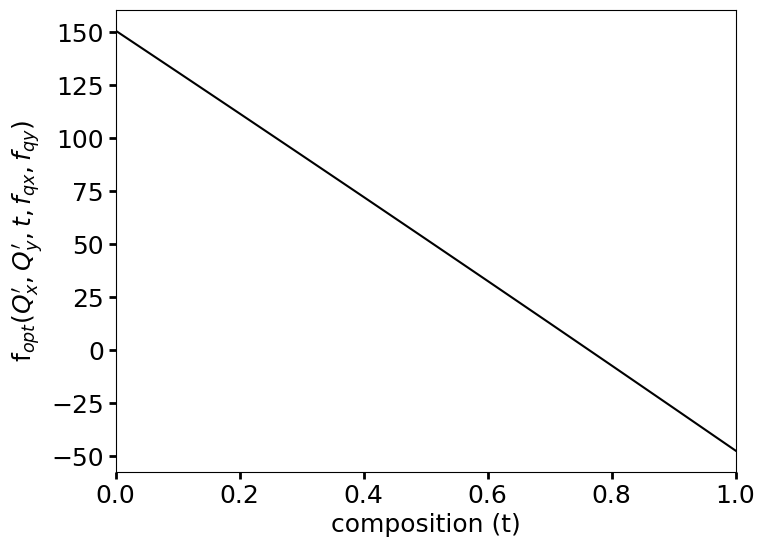

Solution for requested peak/point: [3710.357856139632, 9907.985045901956]
	-Composition (%)         : 76.38
	-Strain-relaxation (%)   : 0.55
** Note: Composition here corresponds to the first binary material used in "list_binary_parameters[0]" list. In this eaxmple, it is Al(N) composition.


In [23]:
## optimize_f_args = (peak_coordinate_for which_to find_results, list_binary_parameters, shift_xy_, mul_fact, alloy_type, structure_type, hkl)
optimize_f_args = (list_binary_parameters, mul_fact, alloy_type, structure_type, hkl)
sol, relaxation = xrd_.find_composition_strain_4_point(find_results_4_peak_shift, reference_peak,
                                                       optimize_f_args, comp_interval=[0, 1],
                                                       root_finding_method='brentq', 
                                                       show_optimization_fn=True)
print('** Note: Composition here corresponds to the first binary material used in "list_binary_parameters[0]" list. In this eaxmple, it is Al(N) composition.')

## 5.2 Calculate no-relaxation line (theoretically calulated + shifted to reference point)
#### Note: This sub-subsection is for visualization 

### 5.2.1 Calculate alloy parameter from binary

In [16]:
comps_ = np.linspace(0.65,1,11) #np.arange(0, 1.0+1e-10, step=0.25) 
AlGaN_a, AlGaN_c, AlGaN_C13, AlGaN_C33, AlGaN_D = \
    gen_fns.alloy_parameters_from_binary(comps_, list_binary_parameters, 
                                         alloy_type=alloy_type, structure_type=structure_type)

### 5.2.2 Completely relaxaed (no-strain) line

In [17]:
rec_space_theor_AlGaN = xrd_.Qxy_theor(AlGaN_a, AlGaN_c, hkl=hkl, structure_type=structure_type)

# 6. Plot reciprocal space (after shift) all together

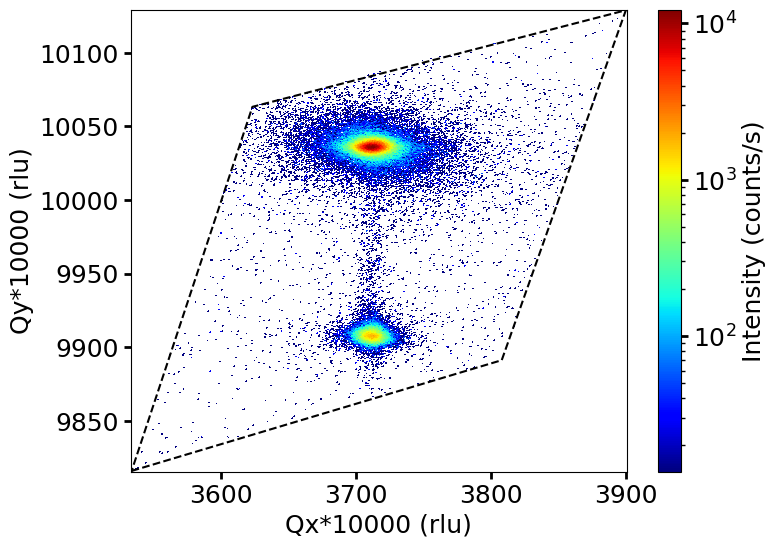

In [18]:
xlabel_text = f'Qx*{mul_fact[0]} (rlu)'
ylabel_text = f'Qy*{mul_fact[1]} (rlu)'
save_file_name = 'AlN_AlGaN_AlN_2reciprocal_space.png' if savefig else None

#====================== Plot the map =================================
fig, ax, _ = xrd_plt.xrd_plot(save_file_name=None, x_values=rec_space_x_shift, 
                              y_values=rec_space_y_shift, z_values=rsm_intesity,threshold_intensity=1e-5,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')

# #==================== add no-strain lines (red dash) ==================
ax.plot(rec_space_theor_AlGaN[0], rec_space_theor_AlGaN[1], color='r', ls='-.')

#==================== add reference lines (black dash) ================
ax.axhline(y=reference_peak[1], ls='--', color='black')
ax.axvline(x=reference_peak[0], ls='--', color='black')

#==================== add required peak (blue cross) ===================
ax.scatter(find_results_4_peak_shift[0], find_results_4_peak_shift[1], marker='o', color='c')

#========= add no_strain-strain connecting points (green dash) =========
for JJ in range(len(comps_)):
    Qxs = np.linspace(rec_space_theor_AlGaN[0][JJ], reference_peak[0])
    Qys = xrd_.get_full_strain_line(Qxs, comps_[JJ], list_binary_parameters, mul_fact, alloy_type, structure_type, hkl)
    ax.plot(Qxs, Qys, color='g', ls='-.')

if savefig:
    xrd_plt.save_figure(save_file_name, fig=fig, dpi=75)
    plt.close()